#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.46514119, -0.76768878, -0.44079201],
       [-0.3643443 , -0.61982812,  0.69502973],
       [-0.80678182, -0.1626869 , -0.56801063]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001230


In [33]:
Ret.shape

(20, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000177


In [37]:
C1(dx,dy,dz,Ret)

array([[ 3.82567403e-02,  8.25255249e-02, -2.82013615e+00,
        -2.39046124e-01, -3.09825198e-01, -2.61512315e+00,
        -1.51239422e+00, -5.76174667e+00, -2.45839506e-01,
        -6.63062654e-01, -5.05285197e-02,  5.24683538e-01,
         2.47390113e-03,  2.12018508e-02,  1.92215917e+00,
        -3.09351209e-01, -1.23791791e-01, -1.60913290e-01,
         5.87714458e-03,  4.19045832e+00],
       [ 1.77169508e+00,  1.59542442e-01,  2.86781671e+00,
         2.13115648e+00,  2.21060349e-01, -3.06241657e+00,
        -1.47263257e+00, -1.81164128e+00,  8.43076404e-01,
        -9.33945837e-01, -5.20198254e-02, -4.38942230e-01,
         2.80870702e-01, -1.01289154e+00,  5.07386287e+00,
        -3.52582933e+00, -2.85131178e+00, -1.12500006e+00,
         3.64684032e+00,  5.62400628e-02],
       [-7.80196278e+00, -2.52408717e-02,  1.34060037e+00,
        -1.65531490e-01,  4.17780692e-01,  3.42387579e+00,
         3.25678268e+00, -9.34525596e-01, -7.44147576e-01,
        -1.63301857e-01,  2.3

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 2.19556731e+02,  1.01678182e+04, -4.47757292e+04],
       [ 4.73616788e+02,  9.15619492e+02, -1.44858219e+02],
       [-1.61848571e+04,  1.64584974e+04,  7.69375105e+03],
       [-1.37189382e+03,  1.22307794e+04, -9.49990840e+02],
       [-1.77809733e+03,  1.26867284e+03,  2.39765757e+03],
       [-1.50082805e+04, -1.75753126e+04,  1.96497394e+04],
       [-8.67968174e+03, -8.45148832e+03,  1.86907864e+04],
       [-3.30668597e+04, -1.03970708e+04, -5.36327411e+03],
       [-1.41088127e+03,  4.83844409e+03, -4.27068819e+03],
       [-3.80533908e+03, -5.35994686e+03, -9.37194899e+02],
       [-2.89984889e+02, -2.98543543e+02,  1.34894028e+02],
       [ 3.01117663e+03, -2.51910435e+03,  9.81612229e+02],
       [ 1.41978025e+01,  1.61192649e+03, -5.81781094e+03],
       [ 1.21678141e+02, -5.81301894e+03, -3.16454581e+03],
       [ 1.10313367e+04,  2.91190712e+04,  8.83319464e+03],
       [-1.77537709e+03, -2.02348542e+04,  9.27281786e+03],
       [-7.10445292e+02, -1.63637751e+04

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000245


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000246


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000028


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-0.22649004,  2.3518475 ,  0.58903179],
       [-0.45718362, -0.53359384, -0.76792197],
       [ 0.64049623, -0.91757147,  0.52028439],
       [ 0.74273693, -0.19165119,  0.45964958],
       [ 1.12938871, -0.67851783,  1.76446406],
       [-0.46566804, -1.73829377, -1.14382046],
       [ 0.25222279, -1.36013563,  1.24011603],
       [-1.76531439,  0.13420484, -0.21623881],
       [ 0.75519274,  0.74146085, -0.47701023],
       [ 1.24628135, -0.82941515, -0.1534209 ],
       [-0.88310706,  0.47152056, -2.21831701],
       [ 0.23353113,  0.59438511,  0.03360762],
       [ 1.46322179,  0.48002998,  0.29058612],
       [ 1.31523713, -0.38186749, -0.37107709],
       [-1.17338349,  1.20934355, -0.41670855],
       [ 0.59209499, -0.61361741,  0.92989216],
       [ 0.34555913,  0.31143917,  0.80474864],
       [ 0.91394671,  3.20114744,  0.77744653],
       [-0.56451826,  0.19285355, -0.68429164],
       [-1.98646004, -0.19945299, -0.04845316]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000310


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000598


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000588


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.65874971,  0.7090009 , -0.566055  ],
       [-2.1090675 ,  1.02929885,  1.15306903],
       [ 0.66284412, -0.06955136, -0.83213147],
       [-1.57626807, -0.3525582 , -1.11092885],
       [-0.16811508,  1.59367265,  1.05595395],
       [-1.17086793,  0.3946672 ,  0.17777036],
       [-0.1647529 , -1.84229323,  0.09210191],
       [ 0.20511277,  0.88306072,  0.91934967],
       [ 0.2265853 ,  0.16172061, -1.26575914],
       [-0.19858412, -0.43464004,  0.24053825],
       [-0.98903295,  0.07393554,  0.15757204],
       [-1.86404719, -0.49130564,  0.01079911],
       [ 1.36457705,  2.94884244,  0.79582986],
       [ 1.07302948, -0.9847598 ,  0.60886232],
       [-0.21894472, -1.93310412, -0.87775889],
       [ 0.29194737,  0.21939622, -0.20437864],
       [ 0.12852118,  1.48180754,  0.70907499],
       [-0.27442824,  0.25698724,  0.27888929],
       [ 0.92035973, -0.29781952,  0.64497198],
       [-1.14372146,  0.21419385, -0.24607733]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-1.57457348e-02, -2.13714641e-03,  1.28952878e-02,
         5.85280589e-03,  2.19555524e-02,  5.26067626e-03,
         2.33357266e-02, -3.14758393e-03, -1.09296357e-02,
         6.04185764e-03, -2.41884503e-02, -5.01696107e-03,
        -1.68029833e-03,  7.72343279e-05, -1.45741648e-02,
         1.38621849e-02,  4.45683459e-03, -2.16505499e-02,
        -7.88571922e-03,  1.34885746e-03],
       [-6.09858286e-02,  7.27731720e-02, -4.63454450e-02,
        -3.93612248e-02, -1.66505613e-01,  1.10322612e-01,
        -1.21871509e-01,  5.84552708e-03,  5.45047437e-02,
         2.65102590e-02,  2.14137909e-01, -1.27393725e-03,
        -1.59908797e-02,  4.89135704e-02,  3.12089669e-02,
        -8.77781000e-02, -7.74583098e-02, -6.96386990e-02,
         6.34416381e-02, -1.29280497e-02],
       [ 2.37445784e-01, -4.92943940e-02, -9.76093891e-02,
        -2.58690996e-02, -7.80822816e-02, -1.69801856e-01,
        -1.38412519e-01,  2.93239367e-02,  6.74181595e-02,
        -9.42385019e-02,  5.5

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001298


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 8.70380460e-08,  1.26468132e-06,  6.26779753e-07,
        -3.46959419e-07, -3.44113970e-06, -1.49460295e-06,
         1.98151667e-07,  2.39387678e-08,  1.53819864e-07,
         1.58685495e-06,  1.19959485e-06, -3.94495186e-07,
        -6.71193933e-07, -1.20925505e-07, -4.58460670e-07,
         2.01010905e-06, -1.15680697e-06, -3.05862347e-06,
        -6.85635396e-07, -1.11147930e-06],
       [ 5.93390133e-03, -7.85948995e-03,  4.79905633e-03,
         1.07914071e-03,  1.30541194e-02,  1.00990574e-02,
         1.12062158e-02,  6.91938322e-03, -1.31243154e-03,
        -6.64727092e-03,  1.40652197e-02,  3.02511021e-03,
        -9.50349993e-03,  2.33993348e-03, -2.27391050e-03,
        -7.54803563e-03,  3.38073749e-03, -3.38387544e-03,
        -1.05798839e-03,  1.27742903e-02],
       [-6.81341862e-03, -4.91531574e-03, -1.11307279e-02,
         2.42562221e-03,  2.17059615e-02,  4.99819279e-03,
        -1.32084168e-02, -7.16155181e-03, -2.41316430e-04,
        -9.38203970e-03, -2.6

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-2.19556731e+02, -4.73616788e+02,  1.61848571e+04,
         1.37189382e+03,  1.77809733e+03,  1.50082805e+04,
         8.67968174e+03,  3.30668597e+04,  1.41088127e+03,
         3.80533908e+03,  2.89984889e+02, -3.01117663e+03,
        -1.41978025e+01, -1.21678141e+02, -1.10313367e+04,
         1.77537709e+03,  7.10445292e+02,  9.23486832e+02,
        -3.37291322e+01, -2.40491825e+04],
       [-1.01678182e+04, -9.15619492e+02, -1.64584974e+04,
        -1.22307794e+04, -1.26867284e+03,  1.75753126e+04,
         8.45148832e+03,  1.03970708e+04, -4.83844409e+03,
         5.35994686e+03,  2.98543543e+02,  2.51910435e+03,
        -1.61192649e+03,  5.81301894e+03, -2.91190712e+04,
         2.02348542e+04,  1.63637751e+04,  6.45641353e+03,
        -2.09293404e+04, -3.22763629e+02],
       [ 4.46475646e+04,  1.66936769e+01, -7.82191559e+03,
         8.21826298e+02, -2.52582211e+03, -1.97779039e+04,
        -1.88189509e+04,  5.23510957e+03,  4.14252365e+03,
         8.09030357e+02, -2.6

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000987


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 1.74183248e+02, -1.24678578e+06, -5.12666649e+05],
       [ 1.14499804e+02, -2.58585457e+06,  1.42936352e+06],
       [-1.35395813e+02, -3.91938795e+05,  1.75966221e+06],
       [-3.80392076e+01,  2.95976785e+05,  8.82620431e+04],
       [ 1.98102776e+02, -1.30227546e+06, -6.98797748e+05],
       [-4.58407379e+01, -4.31451429e+04,  5.06208473e+05],
       [ 8.23550502e+01,  5.99015653e+05, -1.43095722e+06],
       [ 5.76538998e+02, -3.42059133e+06, -2.40315570e+06],
       [ 7.55920273e+01, -1.46286544e+06,  6.99345179e+05],
       [-5.84672264e+01,  3.28151375e+06, -2.69107217e+06],
       [-8.93615601e+01, -8.35491814e+04,  9.86241027e+05],
       [-2.90886849e+01,  3.74700772e+05, -8.08798195e+04],
       [ 4.28828510e+01,  3.14803224e+02, -4.33496808e+05],
       [-7.77588329e+01,  9.50900281e+05, -1.65466041e+05],
       [-4.10239496e+01,  2.62930921e+06, -2.21503819e+06],
       [ 5.75164124e+01, -1.83175374e+06,  1.25084336e+06],
       [ 2.63079128e+02, -7.26469910e+05

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-4.28764072e+08, -5.13091125e+07,  1.24636133e+08],
       [-1.00636292e+08,  1.42926389e+08,  2.58575495e+08],
       [-1.60834409e+08,  1.75950298e+08,  3.91779577e+07],
       [-8.18963937e+08,  8.74512687e+06, -2.96787518e+07],
       [ 5.54103772e+05, -6.98797200e+07,  1.30227601e+08],
       [-2.77910593e+08,  5.05933341e+07,  4.28700253e+06],
       [ 1.87769102e+07, -1.43093863e+08, -5.98997065e+07],
       [-4.49008721e+07, -2.40320016e+08,  3.42054688e+08],
       [-2.24029851e+07,  6.99323000e+07,  1.46284327e+08],
       [-6.49165188e+08, -2.69171485e+08, -3.28215640e+08],
       [-7.35223981e+08,  9.85513155e+07,  8.28213464e+06],
       [-6.67497679e+08, -8.15406423e+06, -3.75361561e+07],
       [ 2.91668053e+08, -4.33208057e+07, -2.60664342e+03],
       [-1.45190375e+08, -1.65609780e+07, -9.51044012e+07],
       [ 7.30461017e+06, -2.21503096e+08, -2.62930198e+08],
       [-8.97575560e+08,  1.24995476e+08,  1.83086519e+08],
       [-3.73731010e+05, -1.93099279e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000127


In [76]:
Re_b(Ret).shape

(20, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000620


In [82]:
d_me_

array([[-2.20609330e-02,  3.78593770e+02, -1.55763994e+02],
       [-6.03229329e-03, -1.05211628e+02,  1.66152293e+02],
       [ 5.60013433e-02, -4.82273054e+02, -8.34012115e+01],
       [-2.84451194e-03,  7.81539661e+02, -7.52845371e+02],
       [ 7.58880768e-04, -1.41563381e+02,  1.33904705e+02],
       [ 4.24236643e-03,  3.13434757e+02, -3.56304991e+02],
       [-8.84698788e-02,  8.67672821e+00,  8.85003107e+02],
       [ 3.02398772e-02, -4.94610260e+02,  1.89166592e+02],
       [ 8.79742814e-02, -8.82566361e+02, -6.06290171e+00],
       [-1.02015847e-02, -5.11811253e+01,  1.54235233e+02],
       [ 3.68587583e-03,  5.53279913e+02, -5.90540900e+02],
       [ 1.45681565e-03,  6.76052302e+02, -6.90802614e+02],
       [-6.45306931e-03,  4.35376901e+02, -3.70213153e+02],
       [ 4.41861570e-03,  1.58749163e+02, -2.03391944e+02],
       [ 4.30621018e-03, -3.33890179e+02,  2.90407830e+02],
       [-2.19719955e-04,  5.54410053e+01, -5.32243092e+01],
       [-4.49975076e-02, -7.16619226e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-2.19556731e+02, -4.73616788e+02,  1.61848571e+04,
         1.37189382e+03,  1.77809733e+03,  1.50082805e+04,
         8.67968174e+03,  3.30668597e+04,  1.41088127e+03,
         3.80533908e+03,  2.89984889e+02, -3.01117663e+03,
        -1.41978025e+01, -1.21678141e+02, -1.10313367e+04,
         1.77537709e+03,  7.10445292e+02,  9.23486832e+02,
        -3.37291322e+01, -2.40491825e+04],
       [-1.01678182e+04, -9.15619492e+02, -1.64584974e+04,
        -1.22307794e+04, -1.26867284e+03,  1.75753126e+04,
         8.45148832e+03,  1.03970708e+04, -4.83844409e+03,
         5.35994686e+03,  2.98543543e+02,  2.51910435e+03,
        -1.61192649e+03,  5.81301894e+03, -2.91190712e+04,
         2.02348542e+04,  1.63637751e+04,  6.45641353e+03,
        -2.09293404e+04, -3.22763629e+02],
       [ 4.46475646e+04,  1.66936769e+01, -7.82191559e+03,
         8.21826298e+02, -2.52582211e+03, -1.97779039e+04,
        -1.88189509e+04,  5.23510957e+03,  4.14252365e+03,
         8.09030357e+02, -2.6

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

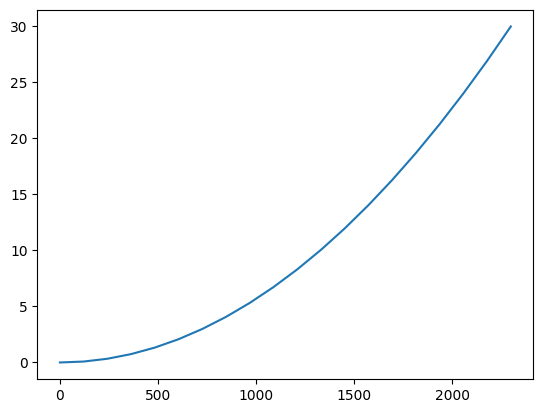

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  1.210e+02 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 491
    fjac: [[ 0.000e+00  0.000e+00 ... -4.199e-17 -3.987e-17]
           [ 0.000e+00  0.000e+00 ...  1.091e-16  1.036e-16]
           ...
           [ 0.000e+00  0.000e+00 ...  3.547e-11 -3.736e-11]
           [ 0.000e+00  0.000e+00 ... -1.366e-13  1.012e-13]]
       r: [-4.698e+02 -4.698e+02 ...  0.000e+00 -0.000e+00]
     qtf: [-1.066e-01 -1.486e+00 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
q0=root_.x

In [106]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

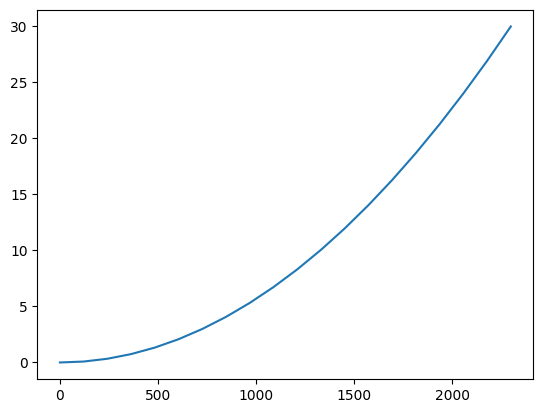

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [113]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [114]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [115]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [116]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [117]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [118]:
fors

array([[-1.51083061e+03,  1.27142468e+01, -1.69792205e+01],
       [ 5.84986992e-09, -4.59340299e-08, -5.99316081e-08],
       [ 6.15400495e-08, -3.87467480e-08,  4.73069122e-08],
       [ 9.82254278e-09,  1.83912481e-08,  4.18613126e-08],
       [-1.38301402e-07, -1.40273187e-07, -1.32263267e-07],
       [ 1.31782144e-07, -4.46525519e-08,  1.08171662e-07],
       [ 6.70552254e-08,  1.39800250e-07,  5.44678187e-08],
       [-9.91858542e-08, -6.34736654e-08,  4.33938112e-08],
       [-2.42143869e-08,  1.59488991e-08,  1.30923581e-07],
       [ 1.04308128e-07,  8.30623321e-08, -7.71833584e-08],
       [-1.15483999e-07, -3.30473995e-08,  9.12114047e-08],
       [ 0.00000000e+00, -1.17653012e-08, -6.73462637e-08],
       [-1.00582838e-07, -4.66825441e-08, -1.35041773e-08],
       [-1.49011612e-08, -1.57160684e-09, -1.69966370e-08],
       [ 2.53319740e-07,  6.69388101e-10,  8.61473382e-09],
       [-1.55808283e-07,  2.04380501e-09, -2.68851692e-09],
       [-7.43316715e-08,  4.54927527e-09

### Vessle Simulation

In [119]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [120]:
N*sampleTime

100.0

In [121]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [122]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [123]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

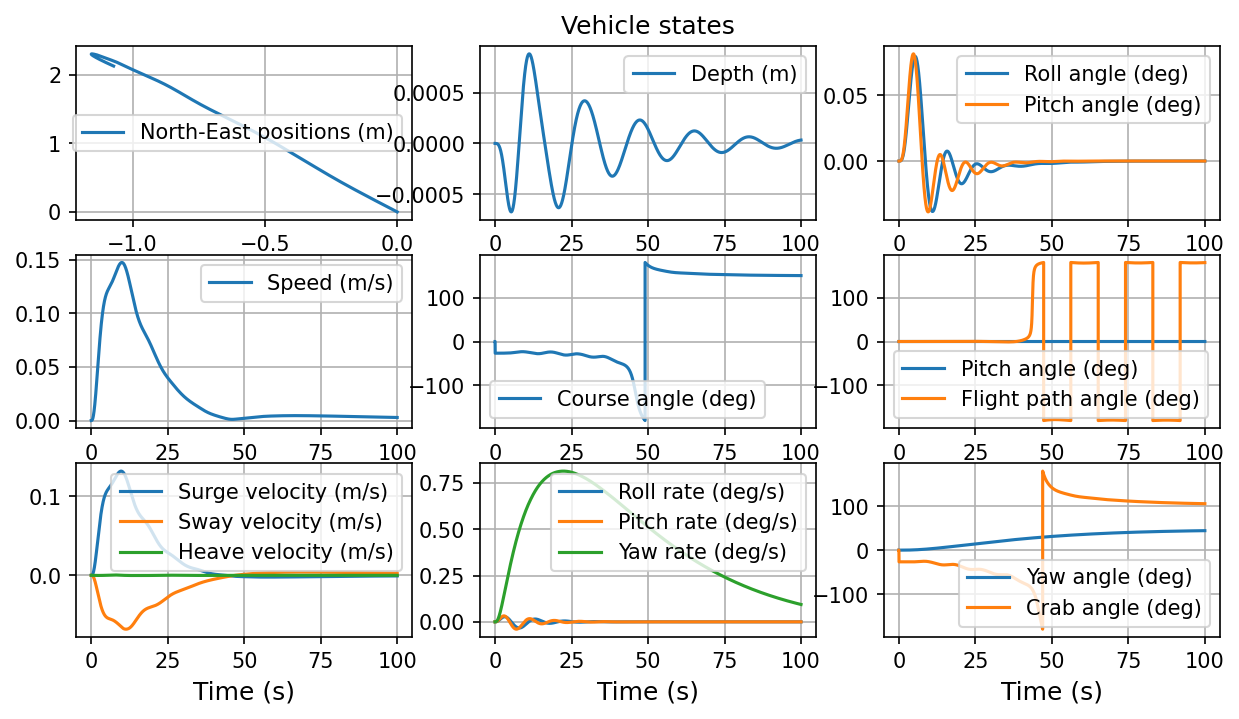

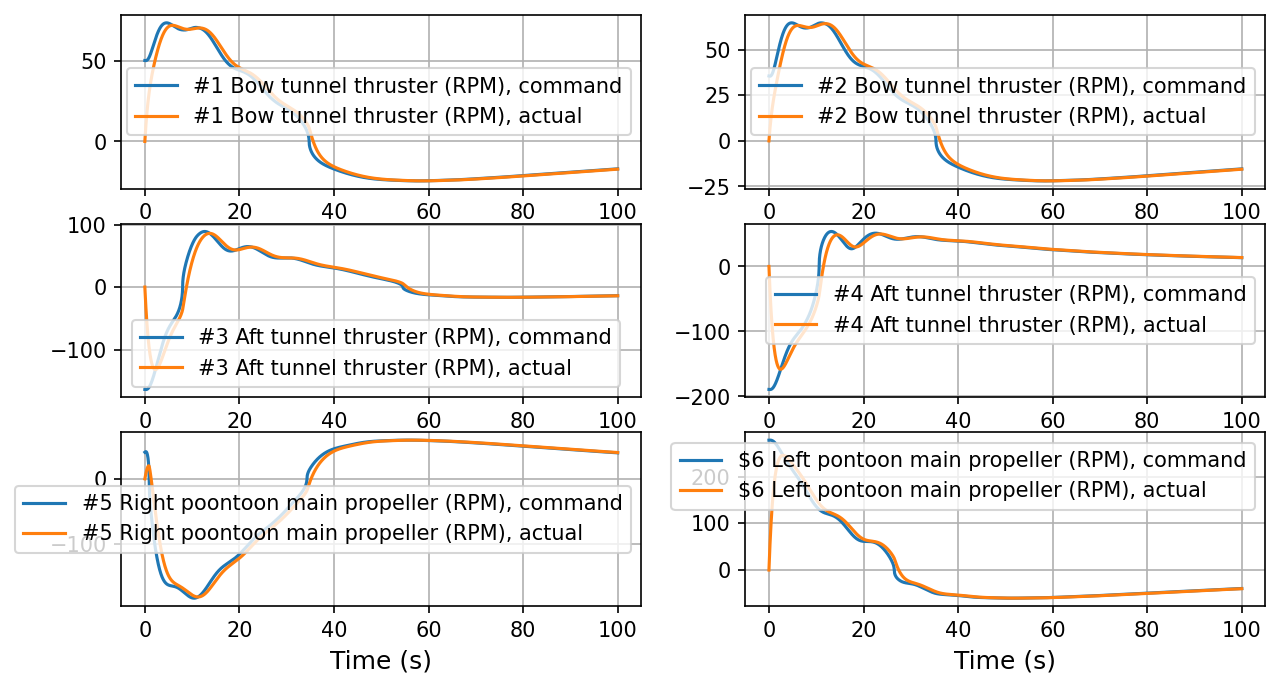

In [124]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [125]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

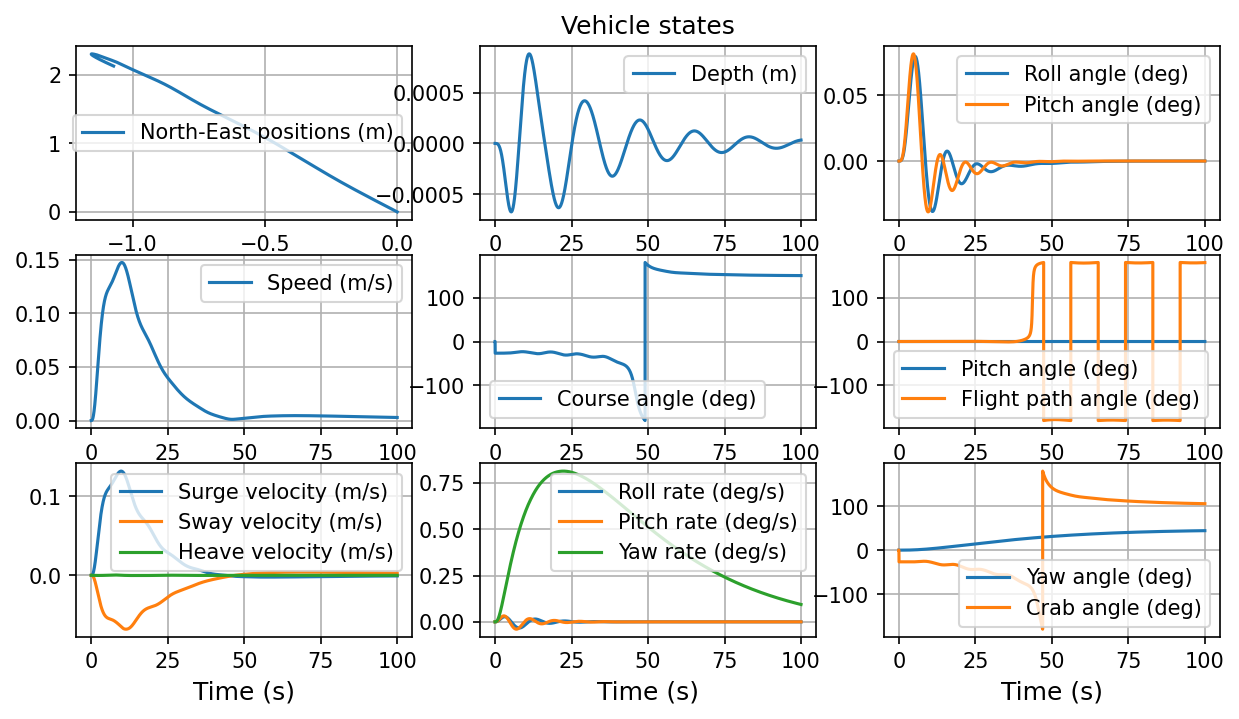

In [126]:
plotVehicleStates(simTime, simData, 3)

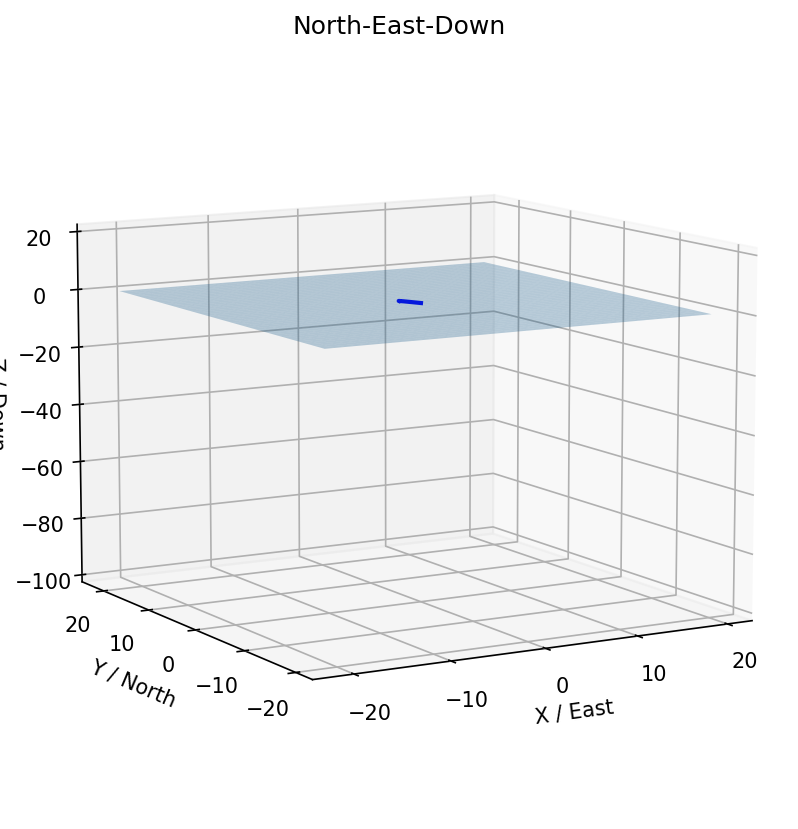

In [127]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [128]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [129]:
idx=1/0.01

In [130]:
idx

100.0

In [131]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [132]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [133]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [134]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [135]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [136]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [137]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
#         + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [138]:
tspan = (0., 100)
T_ = MyTime()

In [139]:
coefs = [1, 1, 1, 1, 1, 1]

In [140]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  3.1486370020116e-05  Iteration wall clock time:  0:00:00.662410
Physical time:  1.052803332766195  Iteration wall clock time:  0:00:06.840784
Physical time:  2.0940321156141106  Iteration wall clock time:  0:00:02.800678
Physical time:  3.0222051006321236  Iteration wall clock time:  0:00:07.644671
Physical time:  4.007453540159343  Iteration wall clock time:  0:00:03.885356
Physical time:  5.041448859798554  Iteration wall clock time:  0:00:04.428361
Physical time:  6.01101801297076  Iteration wall clock time:  0:00:03.705526
Physical time:  7.045806503483268  Iteration wall clock time:  0:00:03.787549
Physical time:  8.044991409796515  Iteration wall clock time:  0:00:03.515305
Physical time:  9.119798435578778  Iteration wall clock time:  0:00:03.237073
Physical time:  10.010032883735992  Iteration wall clock time:  0:00:03.335092
Physical time:  11.099853822555772  Iteration wall clock time:  0:00:02.598804
Physical time:  12.136771263113058  Iteration wall clock ti

### Results

In [141]:
fin=us

In [142]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.149e-03 ...  9.987e+01  1.000e+02]
        y: [[ 0.000e+00  3.082e-15 ...  2.567e+00  2.571e+00]
            [ 1.210e+02  1.210e+02 ...  1.210e+02  1.210e+02]
            ...
            [ 0.000e+00 -1.381e-05 ... -1.416e-03 -1.511e-03]
            [ 0.000e+00 -1.540e-05 ... -1.591e-03 -1.696e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 374
     njev: 0
      nlu: 0

In [143]:
t=fin.t

In [144]:
fin=fin.y.T

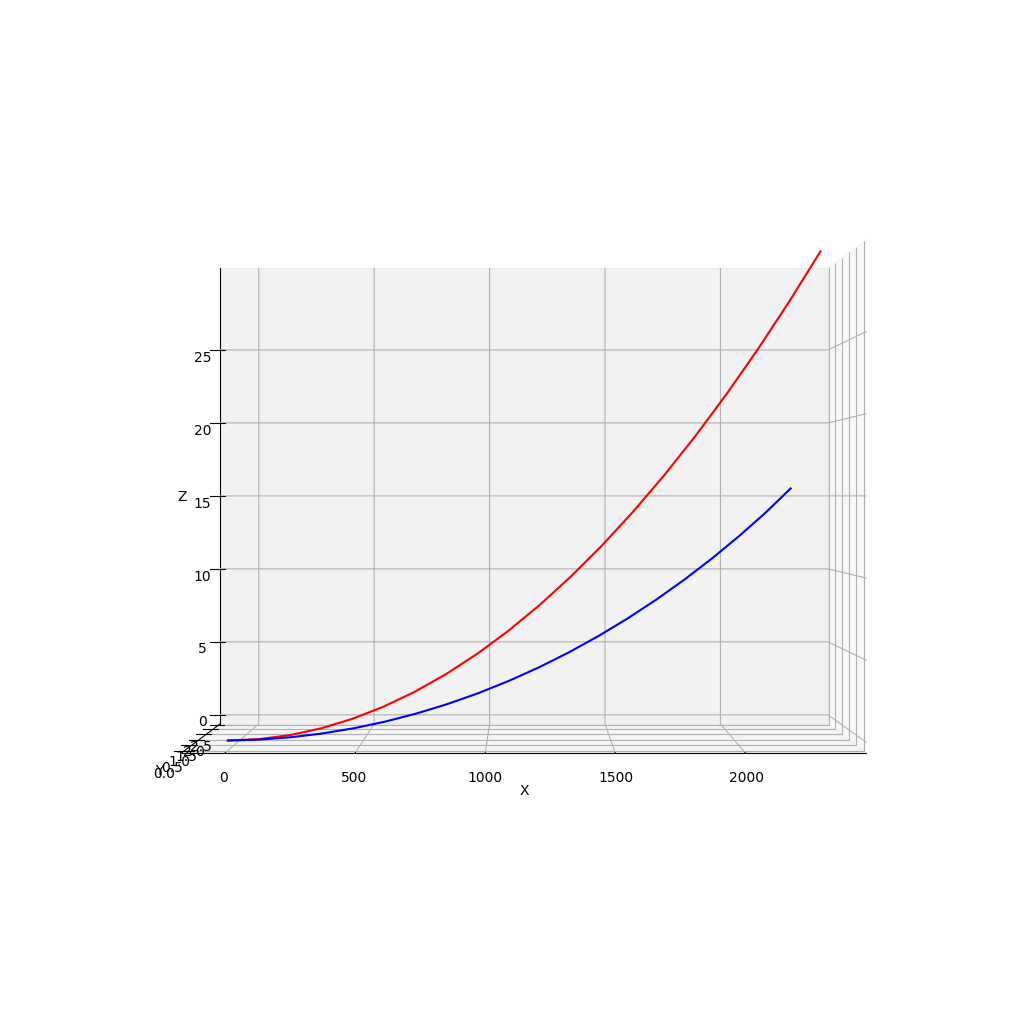

In [145]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [146]:
X,Y,Z

(array([   2.57095965,  120.96556212,  241.93113142,  362.89670795,
         483.86229161,  604.82788228,  725.79347987,  846.75908425,
         967.72469533, 1088.69031299, 1209.65593712, 1330.62156761,
        1451.58720437, 1572.55284727, 1693.51849622, 1814.48415111,
        1935.44981182, 2056.41547827, 2177.38115033, 2295.76126715]),
 array([-0.00575914,  0.00581702,  0.03072739,  0.06855211,  0.11924101,
         0.18274331,  0.25900763,  0.347982  ,  0.44961384,  0.56384997,
         0.69063662,  0.82991939,  0.9816433 ,  1.14575276,  1.32219159,
         1.51090298,  1.71182953,  1.92491323,  2.15009548,  2.38693948]),
 array([2.91553376e-03, 5.07302860e-02, 1.76045383e-01, 3.81472281e-01,
        6.68174242e-01, 1.03731238e+00, 1.49004563e+00, 2.02753071e+00,
        2.65092211e+00, 3.36137205e+00, 4.16003045e+00, 5.04804490e+00,
        6.02656063e+00, 7.09672048e+00, 8.25966488e+00, 9.51653180e+00,
        1.08684567e+01, 1.23165727e+01, 1.38620100e+01, 1.55073038e+01]))

In [147]:
X0,Y0,Z0

(array([   0.        ,  120.9655595 ,  241.93111899,  362.89667849,
         483.86223798,  604.82779748,  725.79335697,  846.75891647,
         967.72447596, 1088.69003546, 1209.65559495, 1330.62115445,
        1451.58671394, 1572.55227344, 1693.51783294, 1814.48339243,
        1935.44895193, 2056.41451142, 2177.38007092, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.08306948,  0.33227809,  0.74762628,  1.32911485,
         2.0767449 ,  2.99051782,  4.07043536,  5.31649953,  6.7287127 ,
         8.30707753, 10.05159699, 11.96227438, 14.0391133 , 16.28211766,
        18.69129171, 21.26663997, 24.00816732, 26.91587892, 29.98978026]))

In [148]:
us=fin.T

In [149]:
us.shape

(240, 59)

In [150]:
12*50

600

In [151]:
us.T[:,4*node_N+49]

array([ 0.00000000e+00,  1.07144428e-14,  1.27021682e-12,  6.35951333e-11,
       -2.64264834e-09, -1.04664316e-08, -2.23040647e-08, -3.55966229e-08,
       -4.89931906e-08, -6.19680851e-08, -7.43033850e-08, -8.58588558e-08,
       -9.64930469e-08, -1.06044860e-07, -1.14342837e-07, -1.21230157e-07,
       -1.26600399e-07, -1.30438717e-07, -1.32859806e-07, -1.34137150e-07,
       -1.34723409e-07, -1.35269002e-07, -1.36648988e-07, -1.40005719e-07,
       -1.46804411e-07, -1.58874738e-07, -1.78358301e-07, -2.07397424e-07,
       -2.47363034e-07, -2.97676274e-07, -3.54938432e-07, -4.13123263e-07,
       -4.63442464e-07, -4.95555020e-07, -5.03485512e-07, -5.00016862e-07,
       -5.26978070e-07, -6.34990481e-07, -7.78042162e-07, -8.27791356e-07,
       -8.12595763e-07, -8.09393136e-07, -9.21503464e-07, -1.08886945e-06,
       -1.19785552e-06, -1.19950125e-06, -1.15987539e-06, -1.22649151e-06,
       -1.39935619e-06, -1.53701312e-06, -1.54660839e-06, -1.47164317e-06,
       -1.49113461e-06, -

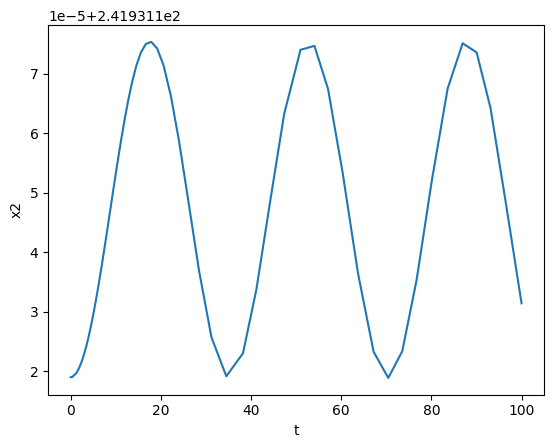

In [152]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

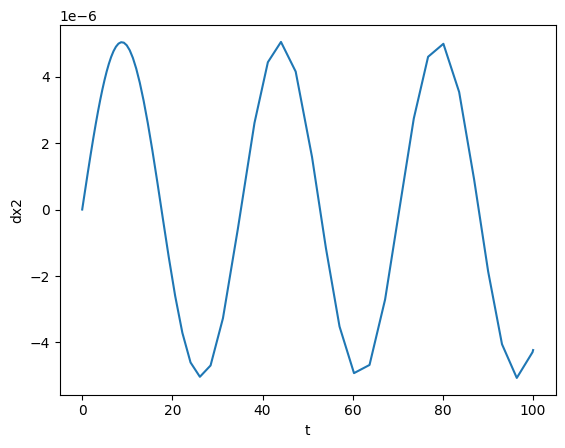

In [153]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

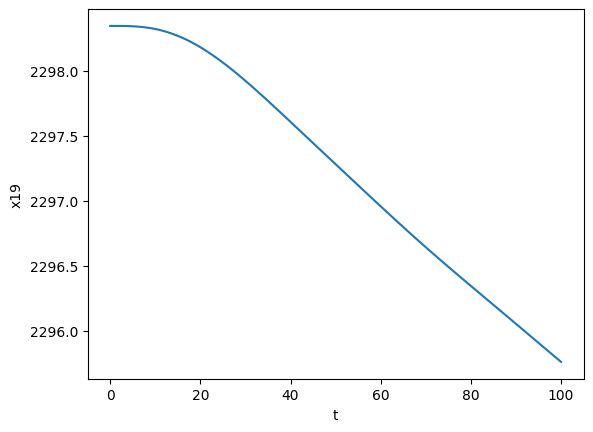

In [154]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

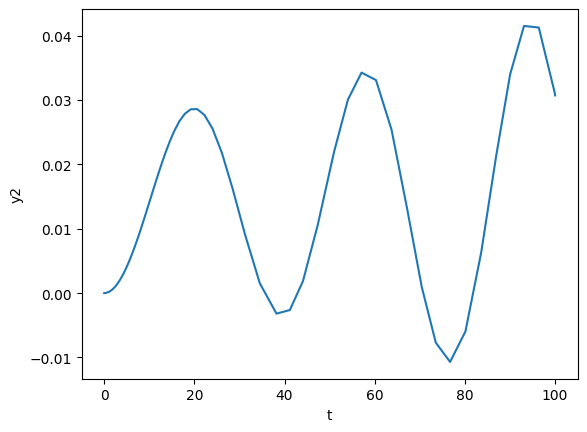

In [155]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

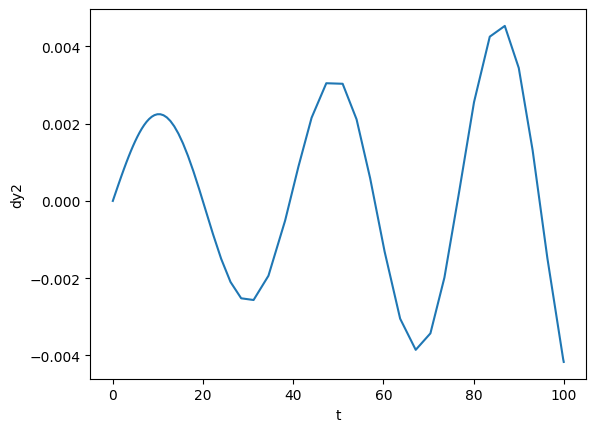

In [156]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

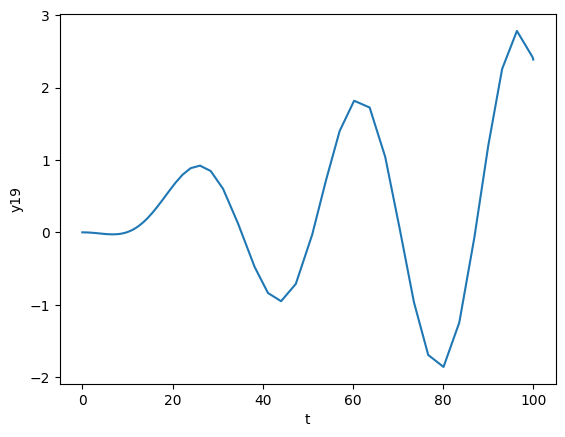

In [157]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

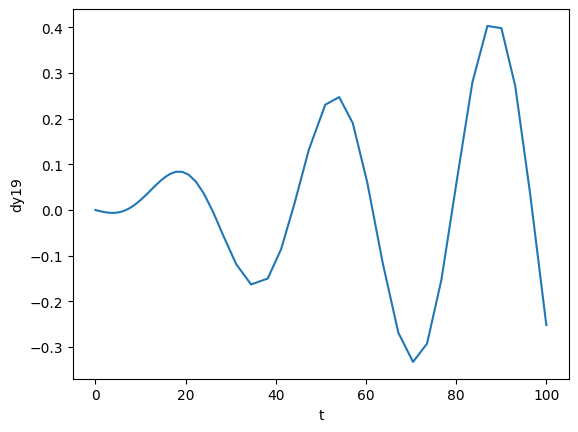

In [158]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

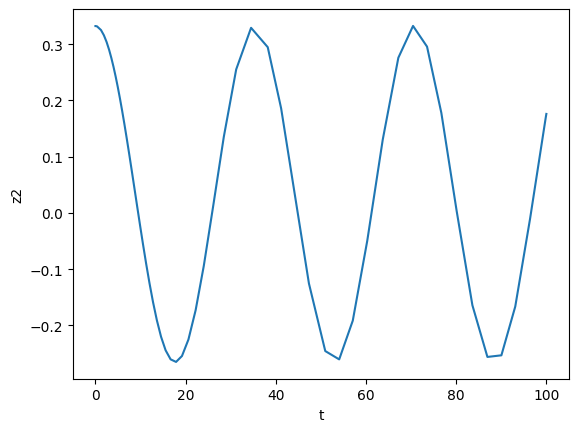

In [159]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

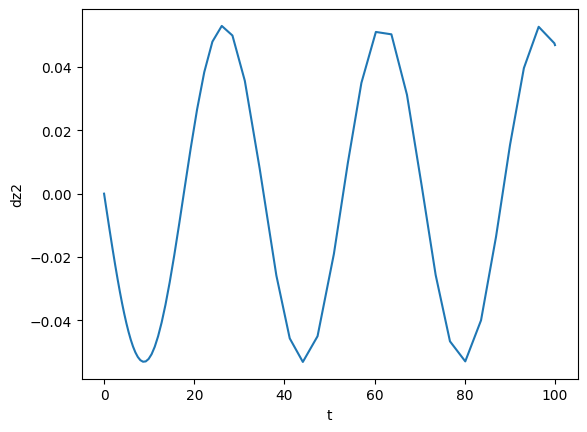

In [160]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

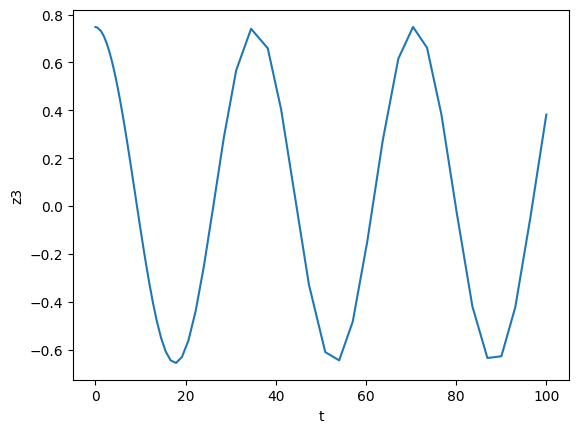

In [161]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

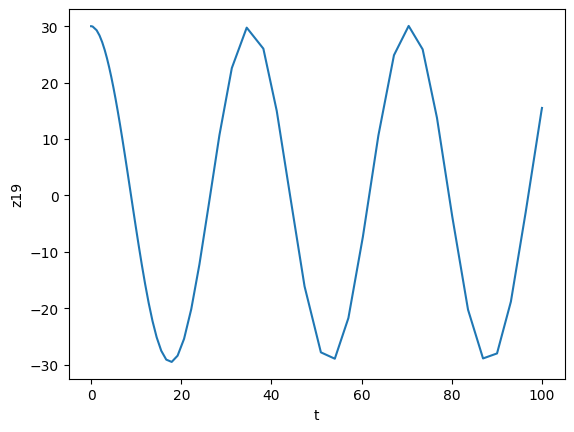

In [162]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

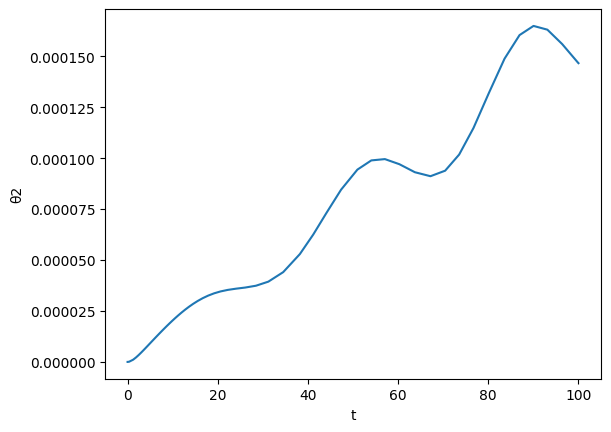

In [163]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

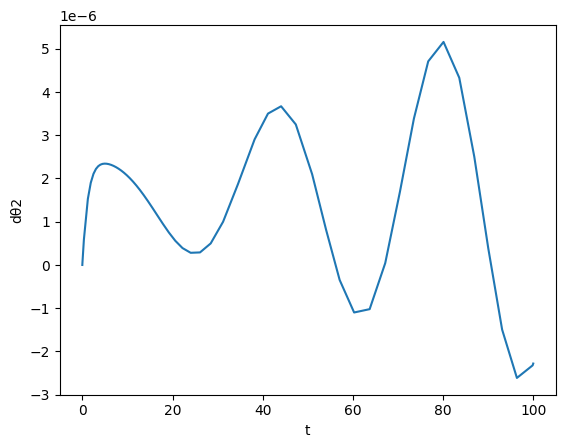

In [164]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

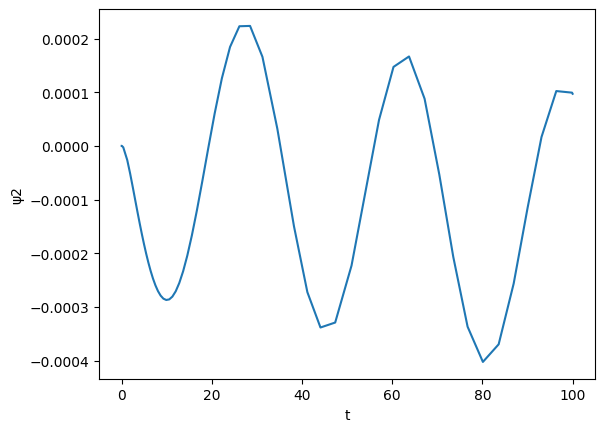

In [165]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

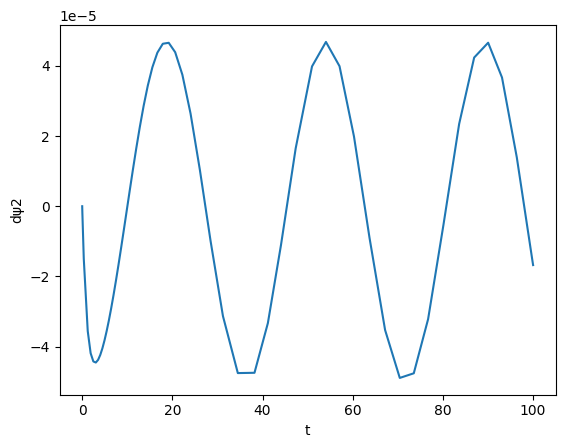

In [166]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

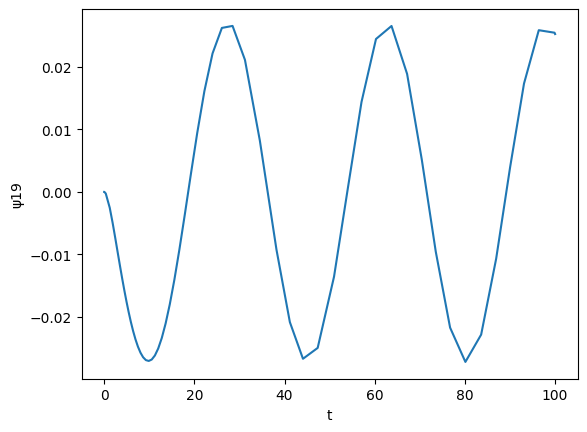

In [167]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()